In [1]:
## CONSTANTS
FDAI_API_KEY = 'fe0aabe5-b190-4b38-9b06-d937aa9a1aee'

In [2]:
## Configuration
BACKTEST_DATE = '2025-06-06'
LOAD_STOCKDATA = False

In [3]:
start_date = "2025-06-01"
end_date = "2025-09-12"

In [4]:
import requests
import pandas as pd
import numpy as np
import os
import datetime

In [5]:
if datetime.datetime.strptime(BACKTEST_DATE, "%Y-%m-%d").weekday() >= 5:
    raise ValueError("BACKTEST_DATE must be a weekday (Monday to Friday).")

In [6]:
working_dir = os.getcwd()

## Data Retrieval

In [7]:
def load_daily_price_data(ticker, start_date, end_date, interval='day', interval_multiplier=1):
    """
    Load daily price data from financialdatasets.ai for given tickers and date range.

    Args:
        tickers (list of str): List of ticker symbols.
        start_date (str): Start date in 'YYYY-MM-DD' format.
        end_date (str): End date in 'YYYY-MM-DD' format.

    Returns:
        dict: Dictionary mapping tickers to their price data (as lists of dicts).
    """

    headers = {
        "X-API-KEY": FDAI_API_KEY
    }

    # create the URL
    url = (
        f'https://api.financialdatasets.ai/prices/'
        f'?ticker={ticker}'
        f'&interval={interval}'
        f'&interval_multiplier={interval_multiplier}'
        f'&start_date={start_date}'
        f'&end_date={end_date}'
    )

    # make API request
    response = requests.get(url, headers=headers)

    # parse prices from the response
    response.raise_for_status()
    return pd.DataFrame(response.json()['prices'])

In [8]:
def load_fundamental_metrics(ticker, period, limit=5):
    
    # add your API key to the headers
    headers = {
        "X-API-KEY": FDAI_API_KEY
    }

      # number of periods to return

    # create the URL
    url = (
        f'https://api.financialdatasets.ai/financial-metrics'
        f'?ticker={ticker}'
        f'&period={period}'
        f'&limit={limit}'
    )

    # make API request
    response = requests.get(url, headers=headers)
    response.raise_for_status()
    # parse financial_metrics from the response
    financial_metrics = response.json().get('financial_metrics')
    return pd.DataFrame(financial_metrics)

In [9]:
tickers = ["AAPL", "MSFT", "NVDA", "TSLA"]

## Valuation Agent

In [10]:
if LOAD_STOCKDATA:
    stock_data = pd.read_csv(os.path.join(working_dir,"stock.csv"))
else:
    df_list =[]
    for i in tickers:
        data = load_daily_price_data(i,start_date,end_date)
        df_list.append(data)
    stock_data = pd.concat(df_list, ignore_index=True)
    stock_data.to_csv(os.path.join(working_dir,"stock.csv"), index=False)

In [11]:
stock_data['date'] = pd.to_datetime(stock_data['time']).dt.date
stock_data['close_pct_change'] = stock_data.groupby('ticker')['close'].pct_change()

In [12]:
stock_data['annualised_5_day_momentum'] = (1 + stock_data['close_pct_change']) ** (252/5) - 1

In [13]:
stock_data['vol_5_daily_unannualized'] = stock_data['close_pct_change'].rolling(5).std(ddof=1)

# annualized 5-day volatility
stock_data['vol_5_annualized'] = stock_data['vol_5_daily_unannualized'] * np.sqrt(252)

In [14]:
stock_data['sharpe_ratio_5_day'] = stock_data['annualised_5_day_momentum'] / stock_data['vol_5_annualized']

In [15]:
stock_data['signal'] = stock_data['sharpe_ratio_5_day'].apply(lambda x: 'buy' if x > 1 else ('sell' if x < -1 else 'hold'))
stock_data

,ticker,open,close,high,low,volume,time,time_milliseconds,date,close_pct_change,annualised_5_day_momentum,vol_5_daily_unannualized,vol_5_annualized,sharpe_ratio_5_day,signal
0,AAPL,200.28,201.70,202.13,200.12,35423294,2025-06-02T04:00:00Z,1748836800000,2025-06-02,NaN,NaN,NaN,NaN,NaN,hold
1,AAPL,201.35,203.27,203.77,200.96,46381567,2025-06-03T04:00:00Z,1748923200000,2025-06-03,0.007784,0.478143,NaN,NaN,NaN,hold
2,AAPL,202.91,202.82,206.24,202.10,43603985,2025-06-04T04:00:00Z,1749009600000,2025-06-04,-0.002214,-0.105687,NaN,NaN,NaN,hold
3,AAPL,203.50,200.63,204.75,200.15,55221235,2025-06-05T04:00:00Z,1749096000000,2025-06-05,-0.010798,-0.421413,NaN,NaN,NaN,hold
4,AAPL,203.00,203.92,205.70,202.05,46607693,2025-06-06T04:00:00Z,1749182400000,2025-06-06,0.016398,1.269985,NaN,NaN,NaN,hold
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,TSLA,354.64,346.40,358.44,344.84,75208290,2025-09-08T04:00:00Z,1757304000000,2025-09-08,-0.012655,-0.473708,0.020984,0.333103,-1.422106,sell
284,TSLA,348.44,346.97,350.77,343.82,53815991,2025-09-09T04:00:00Z,1757390400000,2025-09-09,0.001645,0.086395,0.018070,0.286854,0.301181,hold
285,TSLA,350.55,347.79,356.33,346.07,72121679,2025-09-10T04:00:00Z,1757476800000,2025-09-10,0.002363,0.126337,0.018242,0.289578,0.436279,hold
286,TSLA,350.17,368.81,368.99,347.60,103756010,2025-09-11T04:00:00Z,1757563200000,2025-09-11,0.060439,18.251923,0.029955,0.475527,38.382531,buy


## Sentiment Agent

In [16]:
## News/Sentiment Data
## Finbert

news_data_aapl = pd.read_json(os.path.join(working_dir,'Data/AAPL.json'))
news_data_msft = pd.read_json(os.path.join(working_dir,'Data/MSFT.json'))
news_data_nvda = pd.read_json(os.path.join(working_dir,'Data/NVDA.json'))
news_data_tsla = pd.read_json(os.path.join(working_dir,'Data/TSLA.json'))
news_data_all = pd.concat([news_data_aapl, news_data_msft, news_data_nvda, news_data_tsla], ignore_index=True)

In [17]:
import torch
from transformers import pipeline

pipe = pipeline("text-classification", model="ProsusAI/finbert")

c:\Users\nedgu\miniconda3\envs\antipodes_agent1\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use cpu


In [18]:
news_data_all['sentiment'] = news_data_all['summary'].apply(lambda x: pipe(x)[0]['label'])

In [19]:
news_data_all['signal'] = news_data_all['sentiment'].map({'positive': 'buy', 'negative': 'sell', 'neutral': 'hold'})
news_data_all

,ticker,title,date,summary,url,sentiment,signal
0,AAPL,Apple weighs using Anthropic or OpenAI to powe...,2025-07-01,Apple is exploring using AI models from Anthro...,https://www.reuters.com/business/apple-weighs-...,negative,sell
1,AAPL,"Apple internally discussed buying Mistral, Per...",2025-08-27,"Apple (AAPL.O), opens new tab has held talks i...",https://www.reuters.com/business/apple-interna...,positive,buy
2,AAPL,Apple's tariff-fueled iPhone sales surge raise...,2025-08-02,Apple's best revenue growth in three years fai...,https://www.reuters.com/business/apples-tariff...,negative,sell
3,AAPL,Musk says xAI to take legal action against App...,2025-08-13,Billionaire Elon Musk said on Monday his arti...,https://www.reuters.com/sustainability/boards-...,negative,sell
4,AAPL,"Apple Posts Big Sales Beat on iPhone Demand, C...",2025-08-01,Apple’s quarterly revenue handily topped analy...,https://www.bloomberg.com/news/newsletters/202...,positive,buy
5,AAPL,"JPMorgan Bumps Apple (AAPL) PT to $250, Keeps ...",2025-07-20,JPMorgan raised Apple’s price target to $250 a...,https://finance.yahoo.com/news/jpmorgan-bumps-...,positive,buy
6,AAPL,Apple is developing specialized chips for smar...,2025-05-09,"Apple (AAPL.O), opens new tab is developing sp...",https://www.reuters.com/world/china/apple-is-d...,positive,buy
7,MSFT,Microsoft and Meta fuel $500-billion gain in A...,2025-07-31,Wall Street's AI heavyweights added a combined...,https://www.reuters.com/business/retail-consum...,positive,buy
8,MSFT,Microsoft sued by authors over use of books in...,2025-06-26,"A group of authors sued Microsoft, alleging it...",https://www.reuters.com/sustainability/boards-...,negative,sell
9,MSFT,Microsoft knew of SharePoint security flaw but...,2025-07-23,"LONDON, July 22 (Reuters) - A security patch M...",https://www.reuters.com/sustainability/boards-...,negative,sell


## Fundamental Agent

In [20]:
df_list = []
for i in tickers:
    data = load_fundamental_metrics(i,"quarterly",5)
    df_list.append(data)
fundamental_data = pd.concat(df_list, ignore_index=True)

fundamental_data['report_period'] = pd.to_datetime(fundamental_data['report_period'])
fundamental_fields = ['ticker', 'report_period', 'fiscal_period', 'period', 'currency','operating_income_growth','operating_margin','operating_cash_flow_ratio', 'receivables_turnover']
fundamental_data_subset = fundamental_data[fundamental_fields]
fundamental_data_subset.sort_values(['ticker', 'report_period'],ascending=[True, True],inplace=True)

C:\Users\nedgu\AppData\Local\Temp\ipykernel_29412\80090463.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  fundamental_data = pd.concat(df_list, ignore_index=True)
C:\Users\nedgu\AppData\Local\Temp\ipykernel_29412\80090463.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fundamental_data_subset.sort_values(['ticker', 'report_period'],ascending=[True, True],inplace=True)


In [21]:
# Calculate % change for each ticker and period for selected columns
cols = ['operating_margin', 'operating_cash_flow_ratio', 'receivables_turnover']
pct_change_df = (
    fundamental_data_subset
    .groupby('ticker')[cols]
    .pct_change()
    .rename(lambda x: f'{x}_pct_change', axis=1)
    .reset_index(drop=True)
    
)
result = pd.concat([fundamental_data_subset.reset_index(drop=True), pct_change_df], axis=1)
result.to_csv(os.path.join(working_dir,'fundamental_data.csv'), index=False)

In [22]:
cutoff_date = pd.to_datetime(BACKTEST_DATE)
filtered = fundamental_data_subset[fundamental_data_subset['report_period'] < cutoff_date]
latest_reports_before_cutoff = filtered.groupby('ticker')['report_period'].max().reset_index()
merged = pd.merge( latest_reports_before_cutoff,  result, on=['ticker', 'report_period'], how='left')


In [23]:
import math
def sigmoid(x, k=10):
    """Sigmoid scaling for percentage values."""
    return 1 / (1 + math.exp(-x / k))

def fundamental_signal_df(df):
    """
    Compute composite score and signal for each row in a DataFrame using fundamental metrics.
    Expects columns:
      - operating_income_growth
      - operating_margin_pct_change
      - operating_cash_flow_ratio_pct_change
      - receivables_turnover_pct_change
    Returns:
      DataFrame with 'fundamental_signal' and 'fundamental_score' columns.
    """
    weights = {
        'income': 0.25,
        'margin': 0.25,
        'ocf': 0.25,
        'receivables': 0.25
    }

    def row_signal(row):
        s_income = sigmoid(row['operating_income_growth'], k =10)
        s_margin = sigmoid(row['operating_margin_pct_change'], k=3)
        s_ocf = sigmoid(row['operating_cash_flow_ratio_pct_change'], k=5)
        s_receivables = sigmoid(row['receivables_turnover_pct_change'], k =3)
        score = (weights['income'] * s_income +
                 weights['margin'] * s_margin +
                 weights['ocf'] * s_ocf +
                 weights['receivables'] * s_receivables)
        if score > 0.67:
            signal = "Buy"
        elif score < 0.33:
            signal = "Sell"
        else:
            signal = "Hold"
        return pd.Series({'fundamental_signal': signal, 'fundamental_score': score})

    return df.apply(row_signal, axis=1)

In [24]:
signal_result = fundamental_signal_df(merged)
fundamental_signal_df = pd.concat([merged, signal_result], axis=1)
fundamental_signal_df

,ticker,report_period,fiscal_period,period,currency,operating_income_growth,operating_margin,operating_cash_flow_ratio,receivables_turnover,operating_margin_pct_change,operating_cash_flow_ratio_pct_change,receivables_turnover_pct_change,fundamental_signal,fundamental_score
0,AAPL,2025-03-29,2025-Q2,quarterly,USD,-0.311713,0.307365,0.165676,1.748039,-0.102822,-0.201006,-0.117198,Hold,0.490956
1,MSFT,2025-03-31,2025-Q3,quarterly,USD,0.067158,0.456298,0.324361,1.402891,0.060548,0.584366,-0.069843,Hold,0.507522
2,NVDA,2025-04-27,2026-Q1,quarterly,USD,-0.130746,0.498684,1.032854,1.949775,-0.224079,0.120928,0.010258,Hold,0.496242
3,TSLA,2025-03-31,2025-Q1,quarterly,USD,-0.765016,0.034600,0.072463,4.715854,-0.687575,-0.566169,-0.290888,Hold,0.467834


## Coordinator

In [25]:

filled_list = []

for ticker in tickers:
    df_ticker = news_data_all[news_data_all['ticker'] == ticker].copy()
    full_dates = pd.date_range(start='2025-05-01', end='2025-08-31', freq='D')
    df_ticker = df_ticker.set_index('date').reindex(full_dates)
    df_ticker['ticker'] = ticker
    df_ticker['signal'] = df_ticker['signal'].ffill()
    df_ticker = df_ticker.reset_index().rename(columns={'index': 'date'})
    filled_list.append(df_ticker)

news_data_all_filled = pd.concat(filled_list, ignore_index=True)
news_data_all_filled['date'] = pd.to_datetime(news_data_all_filled['date']).dt.date

In [26]:

fundamental_signal_df['report_period'] = pd.to_datetime(fundamental_signal_df['report_period'])
filled_list = []

for ticker in tickers:
    df_ticker = fundamental_signal_df[fundamental_signal_df['ticker'] == ticker].copy()
    full_dates = pd.date_range(start='2025-03-27', end='2025-08-31', freq='D')
    df_ticker = df_ticker.set_index('report_period').reindex(full_dates)
    df_ticker['ticker'] = ticker
    df_ticker['fundamental_signal'] = df_ticker['fundamental_signal'].ffill()
    df_ticker['fundamental_score'] = df_ticker['fundamental_score'].ffill()
    df_ticker = df_ticker.reset_index().rename(columns={'index': 'report_period'})
    filled_list.append(df_ticker)

fundamental_signal_df_filled = pd.concat(filled_list, ignore_index=True)
fundamental_signal_df_filled['date'] = pd.to_datetime(fundamental_signal_df_filled['report_period']).dt.date

In [27]:
combined_signal_df = pd.merge(stock_data[['ticker','close','date','signal']], news_data_all_filled[['date', 'ticker', 'signal']], on=['date', 'ticker'], how='inner', suffixes=('_price', '_news'))
combined_signal_df = pd.merge(combined_signal_df, fundamental_signal_df_filled[['date', 'ticker', 'fundamental_signal']], on=['date', 'ticker'], how='inner')

In [28]:
def combine_signals(*signals):
    """
    Combine multiple signals ('buy', 'hold', 'sell') into a final signal.
    Returns 'buy' if sum > 0, 'hold' if sum == 0, 'sell' if sum < 0.
    """
    mapping = {'buy': 1, 'hold': 0, 'sell': -1}
    total = 0
    for sig in signals:
        if isinstance(sig, str):
            total += mapping.get(sig.lower(), 0)
    if total > 0:
        return 'buy'
    elif total < 0:
        return 'sell'
    else:
        return 'hold'

In [29]:
combined_signal_df['final_signal'] = combined_signal_df.apply(
    lambda row: combine_signals(row['signal_price'], row['signal_news'], row['fundamental_signal']),
    axis=1
)
combined_signal_df

,ticker,close,date,signal_price,signal_news,fundamental_signal,final_signal
0,AAPL,201.70,2025-06-02,hold,buy,Hold,buy
1,AAPL,203.27,2025-06-03,hold,buy,Hold,buy
2,AAPL,202.82,2025-06-04,hold,buy,Hold,buy
3,AAPL,200.63,2025-06-05,hold,buy,Hold,buy
4,AAPL,203.92,2025-06-06,hold,buy,Hold,buy
...,...,...,...,...,...,...,...
247,TSLA,346.60,2025-08-25,buy,sell,Hold,hold
248,TSLA,351.67,2025-08-26,buy,sell,Hold,hold
249,TSLA,349.60,2025-08-27,hold,sell,Hold,sell
250,TSLA,345.98,2025-08-28,hold,sell,Hold,sell


## Backtest

In [30]:
BACKTEST_DATE

'2025-06-06'

In [31]:
backtest_signals = combined_signal_df[combined_signal_df['date'] == pd.to_datetime(BACKTEST_DATE).date()]

In [32]:
def get_portfolio_weights(df, filter_signal = None):
    # Filter only buy signals
    if filter_signal:
        df = df[df['final_signal'] == filter_signal]
    # Count buys per date
    counts = df.groupby('date')['ticker'].count().rename('count')
    # Merge buy counts back to buy_df
    df = df.merge(counts, on='date')
    # Assign equal weights per buy per date
    df['weight'] = 1 / df['count']
    # Return weights DataFrame
    return df[['date', 'ticker', 'weight']]

In [33]:
port_wts = get_portfolio_weights(backtest_signals, 'buy')
bench_wts = get_portfolio_weights(backtest_signals)

In [34]:
stock_data['daily_return'] = stock_data.groupby('ticker')['close'].pct_change()

In [35]:
def portfolio_performance(weights_df, returns_df, start_date=None):
    """
    Calculate total cumulative return, annualised return, Sharpe ratio, volatility, and daily portfolio returns.
    If weights are missing for some days, forward fill them using stock_data dates.

    Args:
        weights_df (pd.DataFrame): columns ['date', 'ticker', 'weight']
        returns_df (pd.DataFrame): columns ['date', 'ticker', 'daily_return']
        start_date (str or datetime, optional): filter start date (inclusive)

    Returns:
        dict: {
            'total_return': ...,
            'annualised_return': ...,
            'sharpe_ratio': ...,
            'volatility': ...,
            'daily_returns': pd.Series
        }
    """
    # Get all dates and tickers from returns_df
    all_dates = returns_df['date'].sort_values().unique()
    all_tickers = returns_df['ticker'].unique()
    # Create full index for all dates and tickers
    full_index = pd.MultiIndex.from_product([all_dates, all_tickers], names=['date', 'ticker'])
    # Reindex weights to full index and forward fill
    weights_ffill = (
        weights_df.set_index(['date', 'ticker'])
        .reindex(full_index)
        .groupby('ticker')
        .ffill()
        .reset_index()
    )
    # Merge with returns
    merged = pd.merge(weights_ffill, returns_df, on=['date', 'ticker'], how='left')
    if start_date is not None:
        merged = merged[merged['date'] >= pd.to_datetime(start_date).date()]
    # Calculate weighted daily return per date
    merged['weighted_return'] = merged['weight'] * merged['daily_return']
    daily_portfolio_return = merged.groupby('date')['weighted_return'].sum()
    # Cumulative return
    total_return = (daily_portfolio_return + 1).prod() - 1
    # Annualised return
    n_days = daily_portfolio_return.shape[0]
    volatility = daily_portfolio_return.std(ddof=1) * np.sqrt(252) if n_days > 1 else np.nan
    if n_days > 0:
        annualised_return = (total_return + 1) ** (252 / n_days) - 1
        sharpe_ratio = daily_portfolio_return.mean() / daily_portfolio_return.std(ddof=1) * np.sqrt(252)
    else:
        annualised_return = np.nan
        sharpe_ratio = np.nan
    return {
        'total_return': total_return,
        'annualised_return': annualised_return,
        'sharpe_ratio': sharpe_ratio,
        'volatility': volatility,
        'daily_returns': daily_portfolio_return
    }
# Example usage:
port_perf = portfolio_performance(port_wts, stock_data[['date', 'ticker', 'daily_return']], start_date=BACKTEST_DATE)
bench_perf = portfolio_performance(bench_wts, stock_data[['date', 'ticker', 'daily_return']], start_date=BACKTEST_DATE)

In [36]:
# Calculate active return and information ratio
active_return = port_perf['total_return'] - bench_perf['total_return']

# Information ratio: active return divided by tracking error (std of active daily returns, annualized)
portfolio_daily = port_perf['daily_returns']
benchmark_daily = bench_perf['daily_returns']
active_daily = portfolio_daily - benchmark_daily
tracking_error = active_daily.std(ddof=1) * np.sqrt(252)
information_ratio = active_return / tracking_error if tracking_error != 0 else np.nan

In [37]:
def dict_subset(d, keys):
    return {k: d[k] for k in keys if k in d}

# Example usage:
subset = dict_subset(port_perf, ['total_return', 'sharpe_ratio'])


In [38]:
results_df = pd.DataFrame([dict_subset(port_perf,['total_return','sharpe_ratio']), dict_subset(bench_perf,['total_return','sharpe_ratio'])], index=['Portfolio', 'Benchmark'])
results_df.loc['Active', ['total_return', 'sharpe_ratio']] = [active_return, information_ratio]
nBuys = backtest_signals[backtest_signals['final_signal'] == 'buy'].groupby('date')['ticker'].count()
results_df['nBuys'] = [nBuys.values[0], np.nan, np.nan]
print(results_df)

           total_return  sharpe_ratio  nBuys
Portfolio      0.166675      2.566865    1.0
Benchmark      0.234636      4.308205    NaN
Active        -0.067961     -0.339514    NaN


In [39]:
backtest_signals

,ticker,close,date,signal_price,signal_news,fundamental_signal,final_signal
4,AAPL,203.92,2025-06-06,hold,buy,Hold,buy
67,MSFT,470.38,2025-06-06,hold,sell,Hold,sell
130,NVDA,141.72,2025-06-06,hold,sell,Hold,sell
193,TSLA,295.14,2025-06-06,hold,sell,Hold,sell


## Outputs

In [40]:
combined_signal_df[['ticker','date','signal_price','signal_news','fundamental_signal','final_signal']].to_csv(os.path.join(working_dir,"Output/picks.csv"), index=False)

In [41]:
results_df.to_csv(os.path.join(working_dir,"Output/performance.csv"), index=True)

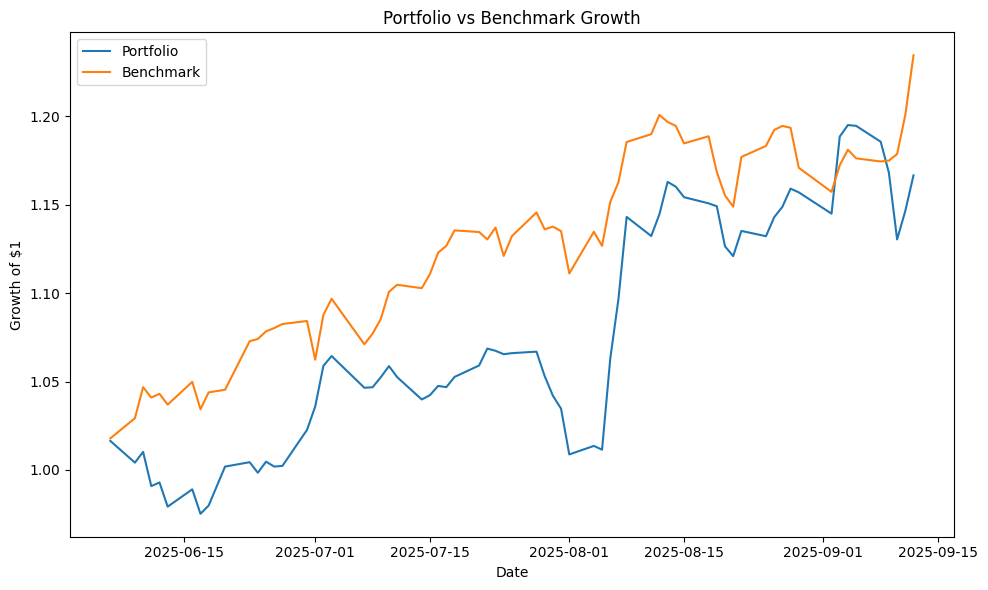

In [42]:
import matplotlib.pyplot as plt

# Calculate cumulative growth for $1 for portfolio and benchmark
portfolio_cum = (port_perf['daily_returns'] + 1).cumprod()
benchmark_cum = (bench_perf['daily_returns'] + 1).cumprod()

plt.figure(figsize=(10, 6))
plt.plot(portfolio_cum.index, portfolio_cum.values, label='Portfolio')
plt.plot(benchmark_cum.index, benchmark_cum.values, label='Benchmark')
plt.ylabel('Growth of $1')
plt.xlabel('Date')
plt.title('Portfolio vs Benchmark Growth')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(working_dir,"Output/performance.png"))
plt.show()

## Tests

In [43]:
## Test 1 - Check get_portfolio_weights function calculates weights correctly

# Create test data
data = [
    {'date': '2025-01-01', 'ticker': 'A', 'final_signal': 'buy'},
    {'date': '2025-01-01', 'ticker': 'B', 'final_signal': 'buy'},
    {'date': '2025-01-01', 'ticker': 'C', 'final_signal': 'sell'},
    {'date': '2025-01-02', 'ticker': 'A', 'final_signal': 'hold'},
    {'date': '2025-01-02', 'ticker': 'B', 'final_signal': 'sell'},
    {'date': '2025-01-02', 'ticker': 'C', 'final_signal': 'hold'},
]
df = pd.DataFrame(data)

# Run function for 'buy' signals
result = get_portfolio_weights(df, filter_signal='buy')

# Check results
assert len(result) == 2, "Should have 2 rows for 2 buys on first date"
assert set(result['ticker']) == {'A', 'B'}, "Tickers should be A and B"
assert all(result['weight'] == 0.5), "Weights should be 0.5 for each buy"
assert all(result['date'].values == ['2025-01-01', '2025-01-01']), "Date should be 2025-01-01"


print("All tests passed for get_portfolio_weights calculating weights correctly.")



All tests passed for get_portfolio_weights calculating weights correctly.


In [44]:
## Test 2 - Check get_portfolio_weights function handles no buys correctly
data = [
    {'date': '2025-01-01', 'ticker': 'A', 'final_signal': 'sell'},
    {'date': '2025-01-01', 'ticker': 'B', 'final_signal': 'sell'},
    {'date': '2025-01-01', 'ticker': 'C', 'final_signal': 'sell'},
    {'date': '2025-01-02', 'ticker': 'A', 'final_signal': 'hold'},
    {'date': '2025-01-02', 'ticker': 'B', 'final_signal': 'sell'},
    {'date': '2025-01-02', 'ticker': 'C', 'final_signal': 'hold'},
]
df = pd.DataFrame(data)

# Run function for 'buy' signals
result = get_portfolio_weights(df, filter_signal='buy')

assert len(result) == 0, "Should have 0 rows for no buys"

print("All tests passed for get_portfolio_weights handling no buys correctly.")


All tests passed for get_portfolio_weights handling no buys correctly.
